<a href="https://colab.research.google.com/github/sayid-alt/sentiment-analysis-nlp/blob/main/Sentiment_analyst_prediction_with_nlp.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

dataset: [kaggle](https://www.kaggle.com/datasets/damirolejar/sentiment-analysis-nlp-trainset-data?select=final_negative.txt)

See copied project on [github](https://github.com/sayid-alt/sentiment-analysis-nlp)

# Import library

In [1]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pickle

from sklearn.model_selection import train_test_split

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Dense, GlobalAveragePooling1D, Embedding, Flatten
from google.colab import files
from sklearn.metrics import ConfusionMatrixDisplay

import os
import zipfile
import urllib.request

# Utilities

In [2]:
DOWNLOAD_URL = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/main/data/text.zip'
DOWNLOAD_DIR = os.path.join(os.getcwd(), 'datasets')

def download_data(url=DOWNLOAD_URL, dir=DOWNLOAD_DIR):
    # Downloading data
    print('Downloading data...')
    if not os.path.exists(dir):
        os.makedirs(dir)

    zip_path = os.path.join(dir, 'text.zip')
    urllib.request.urlretrieve(url, zip_path)
    print(f'Success downloading data to {zip_path}')

    # Extract zip file
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        zip_ref.extractall(dir)
        print(f'Success extracting data to {dir}')


# prep data from text file to variable in list type
def prep_data_txt(filepath):
  '''
    filepath: path for text file
    return: list of text
  '''
  datalist = []
  with open(filepath, 'r') as file:
    lines = file.readlines()
    for line in lines:
      datalist.append(line.strip())
  return datalist


# retrieve data
def retrieve_sentiment_data():
  '''
    return: neg_text, pos_text, ne_text as the dataset for sentiment analysis
  '''
  neg_text = prep_data_txt(os.path.join(data_dir, 'final_negative.txt')) #negative data
  pos_text = prep_data_txt(os.path.join(data_dir, 'final_positive.txt'))# positif data
  ne_text = prep_data_txt(os.path.join(data_dir, 'final_neutral.txt'))

  print(f'Negative data length: {len(neg_text)}')
  print(f'Positive data length: {len(pos_text)}')
  print(f'neutral data length: {len(ne_text)}')

  return neg_text, pos_text, ne_text


def stratified_split(df):
  # split data using stratified with size train/val/test 80/10/10 respectively
  train_index, test_index = train_test_split(df,
                                             test_size=0.2,
                                             random_state=42)


  # split throug test size for get validation split
  val_index, test_index = train_test_split(test_index,
                                             test_size=0.5,
                                             random_state=42)

  value_count = df['label'].value_counts()
  train_count = train_index['label'].value_counts()
  val_count = val_index['label'].value_counts()
  test_count = test_index['label'].value_counts()

  print(f'Value count:\n{value_count}')
  print(f'-----------\nTrain count:\n{train_count}')
  print(f'Val count:\n{val_count}')
  print(f'Test count:\n{test_count}')

  return train_index, val_index, test_index




# Download data

In [3]:
download_data()

Success downloading data to /content/datasets/text.zip
Success extracting data to /content/datasets


# Generate Data

In [4]:
data_dir = os.path.join(DOWNLOAD_DIR, 'text')
print(os.listdir(data_dir))

['final_negative.txt', 'final_neutral.txt', 'final_positive.txt']


In [5]:
neg_text, pos_text, ne_text = retrieve_sentiment_data()

Negative data length: 99999
Positive data length: 100000
neutral data length: 99999


# Data Preprocessing

## Distribution

Below we merge all data into 3 sentiment categories:
- 0: Negative sentiment
- 1: Positif sentiment
- 2: neutral sentimen

In [6]:
df = pd.DataFrame({
    'sentiment' : neg_text + pos_text + ne_text,
    'label' : ['negative'] * len(neg_text) + ['positive'] * len(pos_text) + ['neutral'] * len(ne_text)
})
df.head()

,sentiment,label
0,Mothers will not give their sons as sacrifices...,negative
1,That which was meant to be conducive to life h...,negative
2,The Jews were expecting the appearance of the ...,negative
3,We have forsaken the path of God; we have give...,negative
4,"Sixth, the Messiah was to gather together all ...",negative


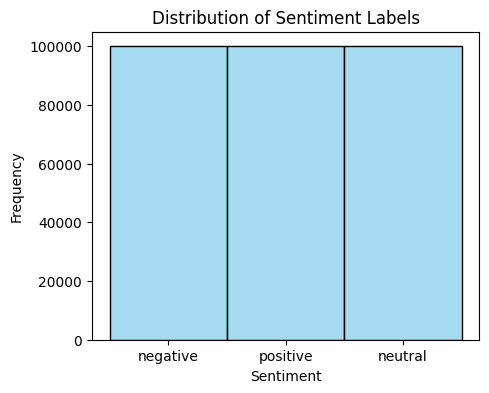

In [7]:
plt.figure(figsize=(5, 4))
sns.histplot(df, x='label', bins=3, color='skyblue')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

## Split data

Split data, using stratified shuffle split from sklearn []:
- Train: 80
- Val: 10
- test: 10

In [8]:
# split data using stratified with size train/val/test 80/10/10 respectively
df_train, df_val, df_test = stratified_split(df)

Value count:
label
positive    100000
negative     99999
neutral      99999
Name: count, dtype: int64
-----------
Train count:
label
negative    80127
positive    79945
neutral     79926
Name: count, dtype: int64
Val count:
label
positive    10027
negative    10021
neutral      9952
Name: count, dtype: int64
Test count:
label
neutral     10121
positive    10028
negative     9851
Name: count, dtype: int64


In [9]:
# check the size of each split
len_df = len(df)
len_train = len(df_train)
len_val = len(df_val)
len_test = len(df_test)

print(f'Train data size: {round(len_train/len_df,2)}')
print(f'Val data size: {round(len_val/len_df,2)}')
print(f'Test data size: {round(len_test/len_df,2)}')

Train data size: 0.8
Val data size: 0.1
Test data size: 0.1


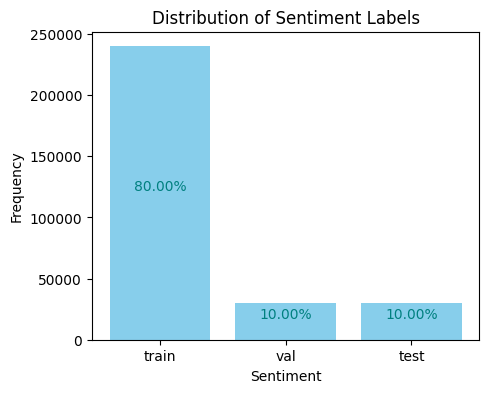

In [10]:
split_name = ['train', 'val', 'test']
split_df = [len_train, len_val, len_test]

plt.figure(figsize=(5, 4))
bars = plt.bar(x=split_name, height=split_df, color='skyblue')

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2.0, height - (height/2.0), '%0.2f%s' % ((height/len_df)*100, '%'), ha='center', va='bottom', color='teal')

plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

## Preparation for training

In [11]:
# split for training portion
X_train, y_train = df_train['sentiment'], df_train['label']
X_val, y_val = df_val['sentiment'], df_val['label']
X_test, y_test = df_test['sentiment'], df_test['label']

In [12]:
# X_train.to_csv('X_train.csv', index=False)
# y_train.to_csv('y_train.csv', index=False)
# X_val.to_csv('X_val.csv', index=False)
# y_val.to_csv('y_val.csv', index=False)
# X_test.to_csv('X_test.csv', index=False)
# y_test.to_csv('y_test.csv', index=False)


In [13]:
# try:
#   from google.colab import files
# except e:
#   print(e)
# else:
#   files.download('X_train.csv')
#   files.download('y_train.csv')
#   files.download('X_val.csv')
#   files.download('y_val.csv')
#   files.download('X_test.csv')
#   files.download('y_test.csv')

### Hyperparameters

In [14]:
# Vocabulary size of the tokenizer
vocab_size = 10000

# Maximum length of the padded sequences
max_length = 50

# Output dimensions of the Embedding layer
embedding_dim = 16

### Tokenize data

In [15]:
tokenizer = Tokenizer(num_words=vocab_size, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)
word_index = tokenizer.word_index

In [16]:
print(len(word_index))

122789


In [17]:
label_tokenizer = Tokenizer()
label_tokenizer.fit_on_texts(y_train)
label_index_word = label_tokenizer.index_word

# start encoder label from 0
labels_encoder = {key - 1: value for key, value in label_index_word.items()}

# Tokenize the label
training_labels = label_tokenizer.texts_to_sequences(y_train)
val_labels = label_tokenizer.texts_to_sequences(y_val)
test_labels = label_tokenizer.texts_to_sequences(y_test)

In [18]:
print(labels_encoder)
np.unique(y_test)

{0: 'negative', 1: 'positive', 2: 'neutral'}


array(['negative', 'neutral', 'positive'], dtype=object)

In [19]:
# convert labels list to np array
# Below arrays are subtracted by one, because all index should start from 0, instead the current label before subtract started with one
training_labels = np.array(training_labels) - 1
val_labels = np.array(val_labels) - 1
test_labels = np.array(test_labels) - 1

print(training_labels.shape)
print(val_labels.shape)
print(test_labels.shape)
len(training_labels), len(val_labels), len(test_labels)

(239998, 1)
(30000, 1)
(30000, 1)


(239998, 30000, 30000)

### Sequence data

In [20]:
sequences_train = tokenizer.texts_to_sequences(X_train)
sequences_val = tokenizer.texts_to_sequences(X_val)
sequences_test = tokenizer.texts_to_sequences(X_test)

### padded data

In [21]:
padded_train = pad_sequences(sequences_train, maxlen=max_length, truncating='post', padding='post')
padded_val = pad_sequences(sequences_val, maxlen=max_length, truncating='post', padding='post')
padded_test = pad_sequences(sequences_test,maxlen=max_length, truncating='post', padding='post')

In [22]:
print(padded_train[0], padded_train.shape)
print(padded_val.shape)
print(padded_test.shape)

[  20    2  575    3    1    1    1    9    1   87   96    5   69 2959
    6  185 1010   15 5956   11    6  337 6734    5   63  143    3   19
   41   58  167  263  537    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0] (239998, 50)
(30000, 50)
(30000, 50)


# Build and compile Model

In [24]:
model = tf.keras.Sequential([
    Embedding(input_dim=vocab_size, output_dim=embedding_dim, input_length=max_length),
    Flatten(),
    Dense(24, activation='relu'),
    Dense(3, activation='softmax')
])

model.summary()

/usr/local/lib/python3.10/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [25]:

model.compile(loss='sparse_categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'],
              )

# Set Callbacks

In [26]:
# early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                  mode='min',
                                                  patience=5, restore_best_weights=True)



# Model checkpoint, saving the best only val_acc

checkpoint_filepath = '/tmp/ckpt/checkpoint-{epoch:02d}-{accuracy:.2f}-{val_accuracy:.2f}.keras'
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    monitor='val_accuracy',
    mode='max',
    save_best_only=False,
    verbose=1)

# Model training

In [27]:
num_epochs=30
history = model.fit(padded_train, training_labels, epochs=num_epochs,
                    validation_data=(padded_val, val_labels), verbose=2,
                    callbacks=[early_stopping, model_checkpoint_callback]
                    )

Epoch 1/30

Epoch 1: saving model to /tmp/ckpt/checkpoint-01-0.75-0.85.keras
7500/7500 - 20s - 3ms/step - accuracy: 0.7465 - loss: 0.5797 - val_accuracy: 0.8456 - val_loss: 0.4146
Epoch 2/30

Epoch 2: saving model to /tmp/ckpt/checkpoint-02-0.81-0.87.keras
7500/7500 - 12s - 2ms/step - accuracy: 0.8122 - loss: 0.4563 - val_accuracy: 0.8673 - val_loss: 0.3658
Epoch 3/30

Epoch 3: saving model to /tmp/ckpt/checkpoint-03-0.84-0.92.keras
7500/7500 - 24s - 3ms/step - accuracy: 0.8437 - loss: 0.3894 - val_accuracy: 0.9151 - val_loss: 0.2657
Epoch 4/30

Epoch 4: saving model to /tmp/ckpt/checkpoint-04-0.87-0.88.keras
7500/7500 - 18s - 2ms/step - accuracy: 0.8701 - loss: 0.3296 - val_accuracy: 0.8847 - val_loss: 0.3350
Epoch 5/30

Epoch 5: saving model to /tmp/ckpt/checkpoint-05-0.89-0.91.keras
7500/7500 - 22s - 3ms/step - accuracy: 0.8900 - loss: 0.2835 - val_accuracy: 0.9079 - val_loss: 0.2858
Epoch 6/30

Epoch 6: saving model to /tmp/ckpt/checkpoint-06-0.91-0.92.keras
7500/7500 - 20s - 3ms/s

# Visualize the results

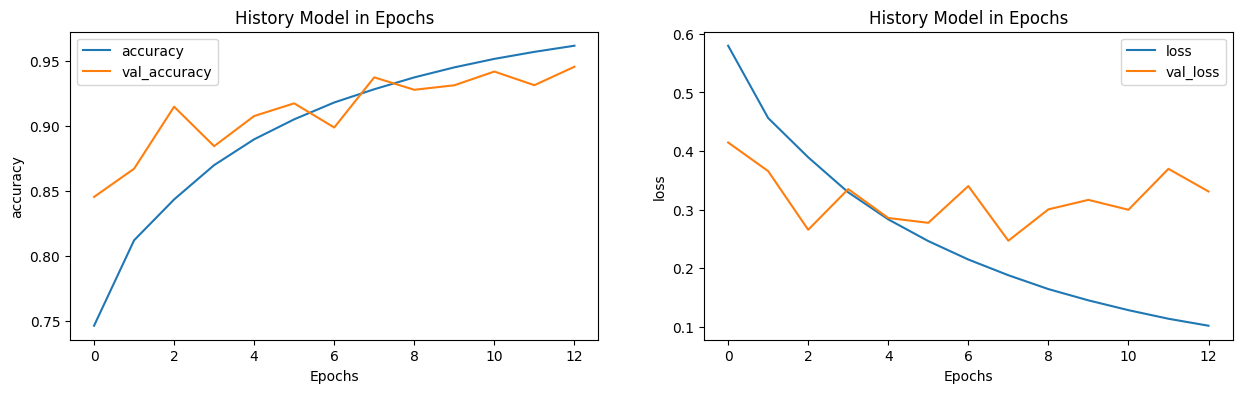

In [40]:
# Plot utility
def plot_graphs(history, strings=['accuracy', 'loss']):
  fig, ax = plt.subplots(figsize=(15, 4), nrows=1, ncols=2)

  for i, string in enumerate(strings):
    ax[i].plot(history.history[string])
    ax[i].plot(history.history['val_'+string])

    ax[i].set_xlabel("Epochs")
    ax[i].set_ylabel(string)
    ax[i].legend([string, 'val_'+string])
    ax[i].set_title('History Model in Epochs')

  plt.show()

# Plot the accuracy and loss
plot_graphs(history)

# Saving best checkpoint model

In [48]:
# download the model of 9-th ckpt for minimum overfitting defined.
model_to_download = '/tmp/ckpt/checkpoint-11-0.95-0.94.keras'
try:
  files.download(model_to_download)

except e:
  print(e)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Evaluate the model

In [23]:
def download_model():
  model_url = 'https://github.com/sayid-alt/sentiment-analysis-nlp/raw/main/model/checkpoint-11-0.95-0.94.keras'
  # Find the position of the last forward slash '/'
  last_slash_index = model_url.rfind('/')

  # Extract the substring from the last slash to the end of the string
  model_name = model_url[last_slash_index + 1:]
  urllib.request.urlretrieve(model_url, model_name)
  print('Downloading model...')
  print('Success downloading model')
  return model_name

model_name = download_model()

Success downloading model


In [24]:
# loaded trained model
loaded_model = tf.keras.models.load_model(model_name)

In [25]:
loss, accuracy = loaded_model.evaluate(padded_test, test_labels)
print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - accuracy: 0.2956 - loss: 7.1995
Loss: 7.233094215393066
Accuracy: 0.29739999771118164


## Prediction

In [26]:
# predict the test labels from dataset

# show prediction softmax probability
prediction = loaded_model.predict(padded_test)
print(prediction)

938/938 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step
[[2.91476487e-09 2.09985837e-01 7.90014148e-01]
 [9.99915242e-01 8.41393339e-05 5.47544175e-07]
 [9.86755311e-01 1.09814275e-02 2.26329127e-03]
 ...
 [8.57707061e-09 9.98457789e-01 1.54215214e-03]
 [1.08124430e-11 1.06182830e-04 9.99893785e-01]
 [4.99898009e-02 3.54883447e-02 9.14521873e-01]]


## Confussion Matrix

In [27]:
labels_encoder

{0: 'negative', 1: 'positive', 2: 'neutral'}

In [28]:
np.unique(test_labels)

array([0, 1, 2])

In [29]:
# Return the highest softmax prob index
pred_labels = np.argmax(prediction, axis=1)
print(pred_labels)
con_mat = tf.math.confusion_matrix(labels=test_labels, predictions=pred_labels).numpy()
con_mat

[2 0 0 ... 1 2 2]


array([[2570, 3798, 3483],
       [4026, 3425, 2577],
       [2733, 4461, 2927]], dtype=int32)

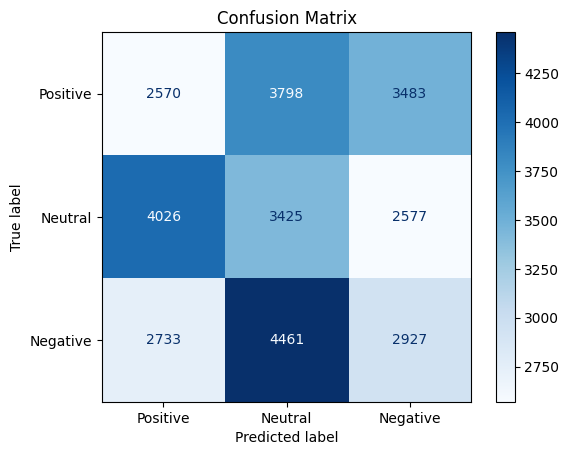

In [33]:
con_mat_disp = ConfusionMatrixDisplay(con_mat, display_labels=['Positive','Neutral', 'Negative'])
con_mat_disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

## Input user

In [ ]:
user_input = input('Enter a sentence: ')

# tokenize the sentence
user_sequence = tokenizer.texts_to_sequences([user_input])

# pad the sequence
user_padded = pad_sequences(user_sequence, maxlen=max_length, truncating='post', padding='post')

# predict the sentiment
prediction = loaded_model.predict(user_padded)

# -- - Summary prediciton ---
print('---- Prediction summary -----')
print(labels_encoder)
print('Softmax probability:', prediction)

# return the highest probability of 3 categories
predicted_index = np.argmax(prediction, axis=1)

# get the predicted label based on highest probability
predicted_label = labels_encoder[predicted_index[0]]
print(f'Predicted sentiment: {predicted_label}')

Enter a sentence: Despite the promising start, the event turned out to be a complete disaster. The organizers were clearly unprepared, leading to long delays and chaotic arrangements. The speakers were underwhelming, offering nothing new or insightful, and the venue was cramped and uncomfortable. Overall, it was a huge waste of time and money. I left feeling extremely disappointed and frustrated.
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step
---- Prediction summary -----
{0: 'positive', 1: 'neutral', 2: 'negative'}
Softmax probability: [[9.4049463e-11 1.7162871e-07 9.9999988e-01]]
Predicted sentiment: negative


# Deployment

## Using Pickle

In [ ]:
with open('model.pkl', 'wb') as file:
  pickle.dump(loaded_model, file)

In [ ]:
files.download('model.pkl')